# **Basics of Mobile Robotics Final Project** 
## **Course: "Basics of Mobile Robotics"(MICRO-452)**
## **Professor: Francesco Mondada**
## **EPFL - December 2023**
### **Authors:**
- Evangelista Santiago Roberto

- Giovine Angelo

- He Weifeng

- Syla Valmir

## **Tables of contents**

- [Demo Videos](#Demo-Videos)

- [Introduction](#Introduction)
  - [Project description and details](#Project-description-and-details)
  - [Modules and libraries required](#Modules-and-libraries-required)

- [Environment](#Environment)

- [Vision](#Vision)
  - [Camera](#Camera)
  - [Environment mapping](#Environment-mapping)
  - [Global obstacle detection](#Global-obstacle-detection)
  - [Robot detection](#Robot-detection)
  - [Goal detection](#Goal-detection)

  

- [Global Navigation](#Global-Navigation)
  - [Visibility graph](#Visibility-graph)



- [Local Navigation](#Local-Navigation)
  - [Local obstacle detection](#Local-obstacle-detection)
  - [Kidnaping](#Kidnaping)

- [Filtering](#Filtering:-Extended-Kalman-Filter)
  - [Why Kalman?](#Deriving-the-state-space-model-of-the-Thymio-Robot)
  - [Deriving the state space model of the Thymio Robot](#Deriving-the-state-space-model-of-the-Thymio-Robot)
  - [Dealing with the input](#Dealing-with-the-input)
  - [Experimentation to derive $Cl$ and $Cr$](#Experimentation-to-derive-$Cl$-and-$Cr$)
  - [Calcultating the covariance matrix of the motion model $Q_t$](#Calcultating-the-covariance-matrix-of-the-motion-model-$Q_t$)
  - [Deriving the observation model of the Thymio Robot](#Deriving-the-observation-model-of-the-Thymio-Robot)
  - [Calcultating the covariance matrix of the observation model $R_t$ ](#Calcultating-the-covariance-matrix-of-the-observation-model-$R_t$ )
  - [Implementing the Extended Kalman Filter](#Implementing-the-Extended-Kalman-Filter)



- [Control law ](#Control-law)

- [Main](#Main)

- [The Code](#The-Code)

- [Sources](#Sources)
  



# **Demo videos**

The optimal path is displayed in white, while the real-time estimated position of the Thymio, obtained through filtering, is indicated by a black dotted line.

Full demo + Normal situation + Kidnapping + Camera obstructed + Local obstacles: https://youtu.be/rz_EOHwGMOw

Full demo: https://youtu.be/DTvLO2GhbcM
    
Normal situation: https://youtu.be/M8M3lAdUMPQ

Kidnapping: https://youtu.be/5M4zRgAHsiA

Camera obstructed: https://youtu.be/vcZKryRRfx0

Local obstacles: https://youtu.be/Q0z2UTtgOtY


# **Introduction**

#### **Project description and details:**
The project is structured around five distinct modules, each tailored to a specific aspect of the Thymio Robot's navigation and operational capabilities:
- Vision Module
- Global Navigation Module
- Local Navigation Module
- Filtering Module
- Robot control

The project uses mainly the camelCase naming convention for variables and functions (everything except the kalman filter). For the kalman filter, the snake case convention was used. This was because of the ditribution of the work among the team members.



#### **Modules and libraries required:**

The following modules and libraries are required to run the code:
- numpy
- matplotlib
- cv2
- math
- time
- pyvisgraph
- tdmclient

# **Environment**

For the environment, a monochromatic blue background was selected, complemented by 2D green obstacles and a yellow target area. The Thymio robot is identified by a distinctive red mask applied to it. The environment was constructed on a pool table.

<div align="center">
    <img src="img/environment.jpeg" alt="Environment on the pool table" width="400" style="margin-right: 10px;"/>
    <img src="img/thymio.jpeg" alt="Thymio with the mentioned mask" width="400"/>
</div>


ChatGPT-4 was used to create polygons as map obstacles. While the model excelled in generating shapes, it faced challenges with non-overlapping shapes in PDFs and random polygon generation. The details were then manually specified, making it a collaborative effort. This experience underscored the limitations of Large Language Models in creative tasks.

<div align="center">
    <img src="img/GPT_error.png" alt="GPT error message" width="450" style="margin-right: 10px;"/>
    <img src="img/GPT_env.png" alt="polygons generated by GPT4 " width="550"/>
</div>

# **Vision**

#### **Camera**

<div align="center">
    <img src="img/iPhone.jpg" alt="very bad image of the concept" width="400"/>
</div>

The camera used in the project was not the "NAME OF THE CAMERA" provided by the course. The development started with the USB camera, but while experimenting, it was discovered that using a macbook, the camera of an iPhone with the same iCloud account is automatically recognized as a webcam wirelessly. This was great considering the camera had to be placed in the roof pointing down at the table. This allowed to stick the phone to the roof and not have any cables hanging from the roof to the computer. Moreover we noticed that the iPhone camera provided smother images then the camera. From python, the camera is recognized as a normal webcam, so the code did not have to be changed. 
#### **Environment mapping**

The computer vision module maps the environment to a 2d plane to allow for correct functioning of the following modules. To do this, four small green markers are placed on the corners of the table. The camera detects the markers (the global obstacles are also green so the external 4 green detected objects are taken) and maps these point to certain point on the plane depending on the aspect ratio of the markers.


<div align="center">
    <img src="img/SCREEN_PRE_DISTORSIONE.jpg" alt="Environment on the pool table from the camera before" width="400" style="margin-right: 10px;"/>
    <img src="img/SCREEN_POST_DISTORSIONE.jpg" alt="Environment on the pool table from the camera after" width="400"/>
</div>

### **Global obstacle detection**

The global obstacle detection is done by detecting the green objects in the environment. These objects are filtered by size and are expanded since the global navigation algorithm used is the visibility graph and the size of the robot is not inherently considered.

<div align="center">
    <img src="img/PHOTO_OBSTACLE.jpg" alt="green obstacle on the table" width="400"/>
</div>

### **Robot detection**

The robot is found by detecting the red mask on the robot. The mask is a composed of a white background and two red rectangles, one large in the back (center between the two wheels, important since this is the center of rotation) and one small in the front. Two rectangles are used to be able to discriminate the angle from 0 to 2pi instead of 0 to pi. This method gives the robot's position and orientation.

<div align="center">
    <img src="img/THYMIO_VISTA_DALL_ALTO.jpg" alt="Thymio seen from above" width="400"/>
</div>


### **Goal detection**
The goal is detected using a yellow detector. The centroid of the largest yellow object is taken as the goal position.

<div align="center">
    <img src="img/PHOTO_GOAL.jpg" alt="yellow obstacle on the table" width="400"/>
</div>

# **Global Navigation**

#### **Visibility graph**
For the global navigation, and like mentioned before, the visibility graph algorithm was used. To do this the library pyvisgraph was used. The library has all the functions needed, including the finding of the shortest path, so no extra libraries (apart from the already used numpy and matplotlib) were needed. It is important to note that the library uses a different coordinate standard than openCV, so an extra function was needed to convert the coordinates. Another important addition was the pushing far of the point in the edge. When initially testing the system issues when a global obstacle was close to the edge were encountered, even if the global obstacles were expanded considering the robot size. To resolve this the points of the global obstacles that are on the edge were pushed a large distance far away from the the edge outwards. This ensured that the path planning algorithm would not consider them.


<div align="center">
    <img src="img/releted_view_from_camera.jpg" alt="Image seen from the camera" width="400"/>
    <img src="img/pointsInPath.png" alt="Plot with points in the shortest path" width="400" style="margin-right: 10px;"/>
</div>

# **Local Navigation**

#### **Local obstacle detection**

To detect the local obstacles the horizontal distance sensors in the front of the robot were used. Depending on in which side the obstacle is detected, the robot will turn in the opposite direction and avoid the obstacle using a squared path manouver. The moving of the robot was done using a direct speed input and timers, since it proved to be simple but effective. The values of the timers were found empirically. Even if considerably precise, at the end of the manouver and once the obstacle has been avoided, the global path planning algorithm is run again to ensure the continuation is smooth and the robot recovers in the best possible manner. This method has some limitations though. The aproximated size of the obstacles has to be known a priori and sufficient place to do the manouver is needed.

#### **Kidnaping**


To detect the kidnaping of the robot the vertical distance sensors on the robot were use. If the robot is lifted from the table a kidnaped flag is activated and while the robot is not positioned backed on the talbe it turns off the motors and waits. When the robot is placed back in the table, a few seconds are waited until the robot is stable and no other perturbations are present (e.g. hands that can be confused as the robot, causing problem with the path planning). In the end, the global path planning algorithm is run again to find the new path to the goal. 

The vertical distance sensors were used in the ground reflected mode. After experimentation it was remarked that this was the mode that showed the most difference when the robot was placed on the table or lifted from it, facilitating the determination of the threshold.


# **Filtering: Extended Kalman Filter**

#### **Why Kalman?**

During the course different Bayes filters were presented to estimate the state of a robot in a given environment. For example, a particle filter could have been used, but it is more computationally expensive and it is not necessary for this application. Considering the project requirements, the Kalman filter was finally chosen. This is a recursive filter that estimates the state of a system from a series of noisy measurements. It is a very efficient algorithm that can be used to solve the localization problem of a robot, but makes a fundamental assumption about the distribution of the noise of the various sensors. In fact, it assumes that the noise is Gaussian distributed, which is not always the case in practice.

In our case, we are dealing with odometry errors then can arise from various sources:

- Sensor measurement errors: The sensors might not be perfectly accurate or might exhibit some drift over time.
- Mechanical Misalignments: Slight imperfections in the robot's construction or wear in components can cause discrepancies.
- Slippage Error: The wheels may slip or lose traction, leading to inaccurate distance measurements.

Each of these error sources contributes in a small and independent manner to the general error. According to the central limit theorem, when a large number of small, independent effects are summed, their overall distribution tends to approach a Gaussian distribution. This implies that even if each individual source of error might not be Gaussian, their cumulative effect tends towards a Normal distribution. 

Considering the above, the Kalman filter seems to be a good choice for this application.

#### **Deriving the state space model of the Thymio Robot**

<div align="center">
    <img src="img/state_space_.png" alt="2D image of a differential drive robot taken from Automatic Addison" width="400"/>
</div>


First, the state and input variables need to be defined. The following state variables will be used: $x$, $y$ for the position, and $\gamma$ for the orientation. Since the actuators of the Thyimio are controlled in speed, the input variables $v$ forward velocity, and $\omega$ angular velocity can be defined. After some trigonometric analysis the state vector $s$ is defined as follows: 
$$
s_{t} =
\begin{bmatrix}
x_{t} \\
y_{t} \\
\gamma_{t}
\end{bmatrix}
=
\begin{bmatrix}
x_{t-1} + v_{t-1}\cos (\gamma_{t-1}) \cdot \Delta t \\
y_{t-1} + v_{t-1}\sin (\gamma_{t-1}) \cdot \Delta t \\
\gamma_{t-1} + \omega_{t-1} \cdot \Delta t
\end{bmatrix}
=
\begin{bmatrix}
f_1 \\
f_2 \\
f_3
\end{bmatrix}
$$

Hence the input vector $u$ is defined as follows:

$$
u_{t} = 
\begin{bmatrix}
    v_{t} \\ 
     \omega_{t}
\end{bmatrix}
$$
If the system were linear it would be defined as:  $s_{t}= A_{t-1}s_{t-1} + B_{t-1}u_{t-1}$, where $A_{t-1}$ is the state matrix and $B_{t-1}$ is the input matrix. Since the system in the presented case is not linear, an approximation of the system can be made using the Jacobian matrix.
The robot moves only when it receives instructions to rotate its wheels. As a result, in this scenario, the $A_{t-1}$ matrix is an identity matrix (linear relation). For the $B_{t-1}$ matrix the Jacobian aproximation matrix is used, which is defined as follows:

$$
B_{t-1} = 
\begin{bmatrix}
\frac{\partial f_1}{\partial v_{t-1}} & \frac{\partial f_1}{\partial \omega_{t-1}} \\
\frac{\partial f_2}{\partial v_{t-1}} & \frac{\partial f_2}{\partial \omega_{t-1}} \\
\frac{\partial f_3}{\partial v_{t-1}} & \frac{\partial f_3}{\partial \omega_{t-1}}
\end{bmatrix}
=
\begin{bmatrix}
\cos(\gamma_{t-1} \cdot \Delta t) & 0 \\
\sin(\gamma_{t-1} \cdot \Delta t) & 0 \\
0 & \Delta t
\end{bmatrix}
$$
If the process noise  $ w_{t} = [ w^1_{t}, w^2_{t}, w^3_{t} ] $
 is also considered, the state space model can be then defined as:
$$s_{t}= A_{t-1}s_{t-1} + B_{t-1}u_{t-1} +w_{t-1}$$
$$
\begin{bmatrix}
x_{t} \\
y_{t} \\
\gamma_{t}
\end{bmatrix}
=
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
x_{t-1} \\
y_{t-1} \\
\gamma_{t-1}
\end{bmatrix}
+
\begin{bmatrix}
\cos(\gamma_{t-1} \cdot \Delta t) & 0 \\
\sin(\gamma_{t-1} \cdot \Delta t) & 0 \\
0 & \Delta t
\end{bmatrix}
\begin{bmatrix}
v_{t-1} \\
\omega_{t-1}
\end{bmatrix}
+
\begin{bmatrix}
w^1_{t-1} \\
w^2_{t-1} \\
w^3_{t-1}
\end{bmatrix}
$$


Note that it is assumed that the process noise is zero-mean Gaussian noise with covariance matrix $Q_k$, which was computed empirically with a process explained in the next section.



#### **Dealing with the inputs**

It is important to note that the state space model is controlled in $v$ forward velocity, and $\omega$ angular velocity. In reality only the speed of the two motors $v_{right}$, and $v_{left}$ of the Thymio can be controlled. A conversion between the speed of the robot $v$ and $\omega$ into $v_{r}$, and $v_{l}$ is then derived using the following equations:

$v_{r} = \frac{2v+\omega L}{2R}$ , $v_{l} = \frac{2v-\omega L}{2R}$

Where $L$ is the distance between the two wheels and $R$ is the radius of the wheels.

In order to control the robot correctly, the multiplication factors $C_r$ and $C_l$ are added to the equations to account for the unit change between the speed and the inputs of the robot.

#### **Experimentation to derive $Cl$ and $Cr$**

In order to use the $Cl$ and $Cr$ values in the program, they need to be obtained empirically. This section contains the collected data and the results. First, each wheel of the Thymio was marked. Then the robot was fixed at a constant speed $spd = 200$  $Thymio units$ and the number of revolutions of each wheel in a fixed time interval $t$ were measured. The experiment was done 10 times and the average values of $Cl$ and $Cr$ were then calculated.


<div align="center">
    <img src="img/Thymio_wheel.jpeg" alt="Description of Thymio wheel" width="500" style="margin-right: 10px;"/>
    <img src="img/Cl_Cr.png" alt="Description of second image" width="300"/>
</div>



$$Cl = 69.33821285 \frac{s}{rad}Thymio units,Cr = 70.74580573 \frac{s}{rad}Thymio units$$



#### **Calcultating the covariance matrix of the motion model $Q_t$**


$$
Q_t = 
\begin{bmatrix}
Var(x_t) & Cov(x_t, y_t) & Cov(x_t, \gamma_t) \\
Cov(y_t, x_t) & Var(y_t) & Cov(y_t, \gamma_t) \\
Cov(\gamma_t, x_t) & Cov(\gamma_t, y_t) & Var(\gamma_t)
\end{bmatrix}
$$

To implement a Kalman filter, the variance of the motion model has te be derived. 
While the odometry system provides only the velocity of the two motors, the geometry of the robot can be used to calculate its position and orientation, hence: $$x=f_1(v_r,v_l) = \frac{R}{2} (v_r + v_l) \cos(\gamma) \Delta t$$ $$y=f_2(v_r,v_l) = \frac{R}{2} (v_r + v_l) \sin(\gamma) \Delta t$$ $$\gamma=f_3(v_r,v_l) =\frac{R}{L} (v_r-v_l) \Delta t$$ where $v_r$ and $v_l$ are the velocity of the two motors, $R$ is the radius of the wheel and $L$ is the distance between the two wheels . The propagation error is then derived: $$Var(x) = (\frac{\partial f_1}{\partial v_r})^2 Var(v_r) + (\frac{\partial f_1}{\partial v_l})^2 Var(v_l) +2(\frac{\partial f_3}{\partial v_r}) (\frac{\partial f_3}{\partial v_l}) Cov(v_r,v_l) $$ $$Var(y) = (\frac{\partial f_2}{\partial v_r})^2 Var(v_r) + (\frac{\partial f_2}{\partial v_l})^2 Var(v_l) +2(\frac{\partial f_3}{\partial v_r}) (\frac{\partial f_3}{\partial v_l}) Cov(v_r,v_l) $$ $$Var(\gamma) = (\frac{\partial f_3}{\partial v_r})^2 Var(v_r) + (\frac{\partial f_3}{\partial v_l})^2 Var(v_l) +2 (\frac{\partial f_3}{\partial v_r}) (\frac{\partial f_3}{\partial v_l}) Cov(v_r,v_l)  $$ 

$v_r$ and $v_l$ are considered uncorrelated, so after deriving the partial derivatives the diagonal terms of $Q_t$ become:

$$Var(x) =  (\frac{R}{2} \cos(\gamma) \Delta t)^2 (Var(v_r)+Var(v_l))$$ 
$$Var(y) = (\frac{R}{2} \sin(\gamma) \Delta t)^2 (Var(v_r)+Var(v_l))$$ 
$$Var(\gamma) =  (\frac{R}{L}\Delta t)^2 (Var(v_r)+Var(v_l))$$

The off-diagonal terms of $Q_t$ can then be calculated (taking in account the error propagation):
$$ Cov(x,y) = Cov(y,x)  = (\frac{\partial f_1}{\partial v_r}) (\frac{\partial f_2}{\partial v_r}) Var(v_r) + (\frac{\partial f_1}{\partial v_l}) (\frac{\partial f_2}{\partial v_l}) Var(v_l) + (\frac{\partial f_1}{\partial v_r}) (\frac{\partial f_2}{\partial v_l}) Cov(v_r,v_l) + (\frac{\partial f_1}{\partial v_l}) (\frac{\partial f_2}{\partial v_r}) Cov(v_l,v_r)$$
$$ Cov(x,\gamma) = Cov(\gamma,x) = (\frac{\partial f_1}{\partial v_r}) (\frac{\partial f_3}{\partial v_r}) Var(v_r) + (\frac{\partial f_1}{\partial v_l}) (\frac{\partial f_3}{\partial v_l}) Var(v_l) + (\frac{\partial f_1}{\partial v_r}) (\frac{\partial f_3}{\partial v_l}) Cov(v_r,v_l) + (\frac{\partial f_1}{\partial v_l}) (\frac{\partial f_3}{\partial v_r}) Cov(v_l,v_r)$$
$$ Cov(y,\gamma) = Cov(\gamma,y) = (\frac{\partial f_2}{\partial v_r}) (\frac{\partial f_3}{\partial v_r}) Var(v_r) + (\frac{\partial f_2}{\partial v_l}) (\frac{\partial f_3}{\partial v_l}) Var(v_l) + (\frac{\partial f_2}{\partial v_r}) (\frac{\partial f_3}{\partial v_l}) Cov(v_r,v_l) + (\frac{\partial f_2}{\partial v_l}) (\frac{\partial f_3}{\partial v_r}) Cov(v_l,v_r)$$

After deriving the partial derivatives the following equations are obtained:

$$ Cov(x,y) = \frac{(R  \Delta t)}{4}^2(\cos(\gamma)\sin(\gamma))(Var(v_r)+Var(v_l)) $$
$$ Cov(x,\gamma) = \frac{(R \Delta t)^2}{2L} \cos(\gamma) (Var(v_r)-Var(v_l) )$$
$$ Cov(y,\gamma) = \frac{(R \Delta t)^2}{2L} \sin(\gamma) (Var(v_r)-Var(v_l)) $$

Now that the covariance matrix $Q_k$ is formulated, the parameters $Var(v_r)$ and $Var(v_l)$ can be obtained empirically. By collecting data from the Thymio proceeding at a constant speed of $200$ $Thymiounits$, the variance of the two motors were obtained (in $(rad/s)^2$): 


<div align="center">
    <img src="img/motor_speed.png" alt="Description of the image" width="400"/>
</div>

$$Var(v_r) = 0.013997244458988999 (rad/s)^2$$
$$Var(v_l) = 0.007137898281767495 (rad/s)^2$$

After some simulation for different values of $\gamma$ from $0°$ to $180°$ it was found that the matrix $Q_t$ is diagonal.
<div align="center">
    <img src="img/Q.png" alt="Description of the image" width="400"/>
</div>

To ensure that the Kalman filter minimizes the variance of the error between the actual state and the predicted state, it is necessary to have a $Q$ matrix that is not time-varying ($Q_t = Q$). To achieve this, it is essential to find a $Q$ matrix that takes scalar inputs. Through simulation,  a matrix $Q$ was selected with values that maximize the variance, thereby obtaining a conservative estimate of the matrix.

$$
Q =
\begin{bmatrix}
0.20000 & 0.00000 & 0.00000 \\
0.00000 & 0.20000 & 0.00000 \\
0.00000 & 0.00000 & 0.00070
\end{bmatrix}

$$

Another crucial aspect to consider is that in the presented model, the input contribution ($ B_{t-1}u_{t-1}$) represents a deterministic quantity. As a result, the matrix $Q$ accounts solely for the state error, excluding any input error. A common practical approach in control theory is to incorporate the input error into an experimental variable, $\alpha$, which requires experimental tuning. Consequently, the actual matrix $Q$ becomes $Q$ =$\alpha  Q$, effectively encompassing the error associated with the input aswell. After some tuning it was found that a good matrix $Q$ for this application was:

$$
Q = 

\begin{bmatrix}
2 & 0 & 0 \\
0& 2 & 0 \\
0 & 0 & 0.07
\end{bmatrix}
$$


#### **Deriving the observation model of the Thymio Robot**

Now that a state space model that includes also the process noise has been derived, an observation model is required in order to be able to implement the Kalman filter. 

An observation model describes how the sensor outputs $y_t$ are related to the state vector $s_t$, considering also a vector of observation noise $ \nu_{t} = [ \nu^1_{t}, \nu^2_{t}, \nu^3_{t} ] ^T$
with zero mean and covariance matrix $R$ (which is computed after some experimentation explained in the next section). 
The observation model is defined as follows: 
$$y_t = H_t s_t + \nu_t$$ 
Since it is possible to detect the position and orientation of the Thyimio in the environment using a camera, the matrix $H$ becomes an identity matrix, hence the observation model can be defined as follows:

$$
y_{t} =
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}

\begin{bmatrix}
x_{t} \\
y_{t} \\
\gamma_{t}
\end{bmatrix}
+
\begin{bmatrix}
\nu^1_{t}\\
\nu^2_{t}\\
\nu^3_{t}
\end{bmatrix}
$$

It's important to notice that our system is robust even to the absence of camera measurements, even if we do not change the $H$ matrix, more details on this topic are provided in the next section. 

#### **Calcultating the covariance matrix of the observation model $R_t$**

The observation vector is denoted as follows:

$$
z_{t} =
\begin{bmatrix}
x^o_{t} \\
y^o_{t} \\
\gamma^o_{t}
\end{bmatrix} 
$$


The variance of the observation will then be:

$$
R_t = 
\begin{bmatrix}
Var(x^o) & Cov(x^o, y^o) & Cov(x^o, \gamma^o) \\
Cov(y^o, x^o) & Var(y^o) & Cov(y^o, \gamma^o) \\
Cov(\gamma^o, x^o) & Cov(\gamma^o, y^o) & Var(\gamma^o)
\end{bmatrix}
$$
Note that those terms are different from the ones of the motion model because the observation noise is related to the camera and the computer vision setup and not to the Thymio. This matrix changes in relation to the visibility of the robot. Two different scenarios are considered: when the Thymio is visible and when it is not. Consequently $2$ matrices $R$ and $R_{nc}$ are defined. If the Thymio is not visible the incertaitnty grows to infinity, corresponding to the case using matrix $R_{nc}$ :
$$
R_{nc} = 
\begin{bmatrix}
\infty &0 & 0 \\
0 & \infty & 0 \\
0 & 0 & \infty 
\end{bmatrix}
$$

Now it is possible to compute $R_t = R$ empirically. To do this, first a callibration grid in an A4 sheet was created, ensuring an accurate positioning of the Thymio robot before detecting its location and orientation. The A4 paper was generated using ChatGPT-4. The LLM generated the following file after the requirements were specified:

<div align="center">
    <img src="img/square_design.png" alt="Description of the image" width="200"/>
</div>

After this, the required variance was computed mesuring the delta between the measure of the Thymio provided by the camera and its real position. The mesurment was repeated 10 times and the average values for $Var(x^o)$, $Var(y^o)$ and $Var(\gamma^o)$ were calculated. To be consistent with the units of the motion model, the camera measurements have been converted from pixels to millimeters.

<div align="center">
    <img src="img/R_exp.jpg" alt="Description of the image" width="300"/>
</div>




$$Var(x^o) = 0.7 (mm)^2$$
$$Var(y^o) = 0.7 (mm)^2$$
$$Var(\gamma^o) = 0.0014 (rad)^2$$

Hence the $R$ matrix is:
$$
R = 
\begin{bmatrix}
0.7 &0 & 0 \\
0 & 0.7 & 0 \\
0 & 0 & 0.0014
\end{bmatrix}
$$


#### **Implementing the Extended Kalman Filter**

Since the model is not linear (the $B$ matrix has a trigonometrical relation with the state varaiable $\gamma$), the implementation of an Extended Kalman Filter is required.

Due to the previous consideration, both the $R$ and the $R_{nc}$ are in place to take in to account when the Thymio is visible and when it is not.

For the implementation, the measurement of the position and orientation of the Thymio in the environment obtained using the camera is refered as 

$$
z_{t} =
\begin{bmatrix}
x_{t} \\
y_{t} \\
\gamma_{t}
\end{bmatrix} 
$$


# **Robot control**

Initially, a simple P controller was employed for the control law, aiming to minimize the perpendicular distance from the robot to the ideal trajectory line. However, this controller led to instability issues. Consequently, the decision was made to switch to a proportional-integral (PI) controller for the angle and a proportional (P) controller for the distance to the optimal path, combined. A differential speed is applied to the wheels of the robot based on the output of the controller.

This controller functions based on the angle error between the desired angle and the current angle of the Thymio robot, along with the perpendicular distance from the Thymio to the line it should be following. Two main modes govern the controller's operation: alignment mode and forward mode.

Alignment Mode: In this mode, the controller exclusively addresses the angle error. It is utilized when the robot reaches each point in the path, preparing for the next segment.


Forward Mode: In this mode, the controller considers both the angle error and the perpendicular distance to the line. It becomes active when the robot is in motion between two points in the path.

<div align="center">
    <img src="img/control.png" alt="Control error diagram" width="300"/>
</div>

# **Main**

The main function is the core of the project. It is responsible for the initialization of the different modules and the communication between them.

The function follows the concept of operations presented in the figure below:

<div align="center">
    <img src="img/conOps.png" alt="Cocept of operations" width="800"/>
</div>

# **The Code**

In [1]:
import numpy as np
import time
import cv2

from src.computerVision import correctPerspectiveStream, findCorners, getPerspectiveMatrix, findThymio, findGlobalObstacles, findGoal
from src.kalman import estimatePosition, inverseSpeedConversion, r11, r22, r33, Cl, Cr, R, L
from src.pathPlanning import buildGraph
from src.robotControl import robotController, checkForObstacles

XYMIRROR = False
IMAGE_WIDTH = 1920
IMAGE_HEIGHT = 1080
POSITION_THRESHOLD = 50
KIDNAPPING_THRESHOLD = 100
KIDNAPPING_TIME = 5


In [2]:
# Note: This function was provided by the course Basics Of Mobile Robotics by Prof. Francesco Mondada
# Source: https://moodle.epfl.ch/course/view.php?id=15293

import tdmclient.notebook
await tdmclient.notebook.start()



@tdmclient.notebook.sync_var
def motors(l_speed=500, r_speed=500, verbose=False):

    global motor_left_target, motor_right_target

    l_speed = int(l_speed)
    r_speed = int(r_speed)
    
    motor_left_target = l_speed
    motor_right_target = r_speed

In [3]:
# Note: This function was provided by the course Basics Of Mobile Robotics by Prof. Francesco Mondada
# Source: https://moodle.epfl.ch/course/view.php?id=15293

@tdmclient.notebook.sync_var 
def horiz_sensor():
    global prox_horizontal
    return prox_horizontal

In [4]:
# Note: This function was provided by the course Basics Of Mobile Robotics by Prof. Francesco Mondada
# Source: https://moodle.epfl.ch/course/view.php?id=15293

@tdmclient.notebook.sync_var 
def getVerticalDistance():
    global prox_ground_reflected
    return prox_ground_reflected


In [5]:
%%run_python

# Note: This function was provided by the course Basics Of Mobile Robotics by Prof. Francesco Mondada
# Source: https://moodle.epfl.ch/course/view.php?id=15293

nf_leds_prox_h(0,0,0,0,0,0,0,0) 
nf_leds_rc(0)
nf_leds_temperature(0, 0)
nf_leds_bottom_right(0,0,0)
nf_leds_bottom_left(0,0,0)
nf_leds_top(0,0,0)
nf_leds_prox_v(0,0)


In [6]:
#Note: these functions are defined here and not in their respective files because they call the functions that interact with the robot defined above

def checkForKidnap():
    ver=getVerticalDistance()
    if ver[0] < KIDNAPPING_THRESHOLD or ver[1] < KIDNAPPING_THRESHOLD:
        print("Kidnapped!")
        motors(0,0)
        return True
    else:
        return False

def avoidObstacle(leftOrRight, initTime, currentTime):
    motors(0,0)
    
    tTurn = 1
    tStraight = 2
    vStraight = 200

    if leftOrRight == 'right':
        l=-200
        r=200
    elif leftOrRight == 'left':
        l=200
        r=-200

    motors(l_speed=l, r_speed=r)
    if currentTime - initTime < tTurn:
        return True

    motors(l_speed=vStraight, r_speed=vStraight)
    if currentTime - initTime < tTurn + tStraight:
        return True
    

    motors(l_speed=-l, r_speed=-r)
    if currentTime - initTime < 2*tTurn + tStraight:
        return True

    motors(l_speed=vStraight, r_speed=vStraight)
    if currentTime - initTime < 2*tTurn + 2.5*tStraight:
        return True

    motors(l_speed=-l, r_speed=-r)
    if currentTime - initTime < 3*tTurn + 2.5*tStraight:
        return True

    motors(l_speed=vStraight, r_speed=vStraight)
    if currentTime - initTime < 3*tTurn + 3.5*tStraight:
        return True

    motors(l_speed=l, r_speed=r)
    if currentTime - initTime < 4*tTurn + 3.5*tStraight:
        return True

    motors(l_speed=0, r_speed=0)

    return False


[ 85 716]


100%|██████████| 8/8 [00:00<00:00, 226.39it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


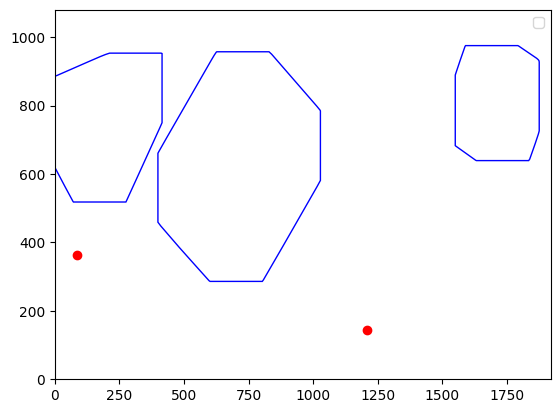

[[1210.  144.]
 [  85.  364.]]
[ 85 715]


100%|██████████| 8/8 [00:00<00:00, 221.52it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


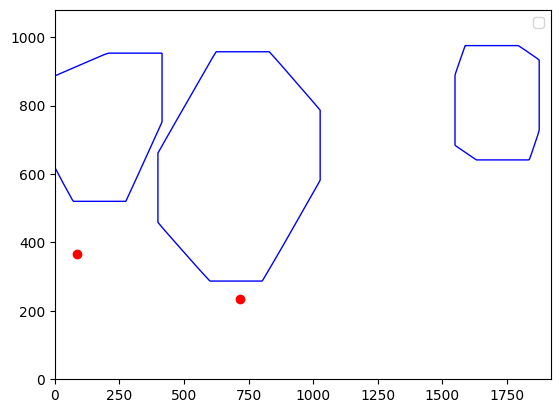

[[717.12725312 235.5483855 ]
 [ 85.         365.        ]]
Kidnapped!
kidnapped
Kidnapped!
kidnapped
Kidnapped!
kidnapped
Kidnapped!
kidnapped
Kidnapped!
kidnapped
Kidnapped!
kidnapped
Kidnapped!
kidnapped
Kidnapped!
kidnapped
Kidnapped!
kidnapped
Kidnapped!
kidnapped
Kidnapped!
kidnapped
Kidnapped!
kidnapped
Kidnapped!
kidnapped
Kidnapped!
kidnapped
Kidnapped!
kidnapped
Kidnapped!
kidnapped
Kidnapped!
kidnapped
Kidnapped!
kidnapped
Kidnapped!
kidnapped
Kidnapped!
kidnapped
[ 85 714]


100%|██████████| 9/9 [00:00<00:00, 203.62it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


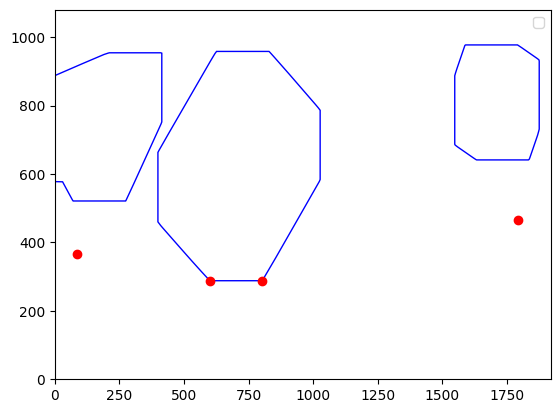

[[1791.64658608  465.17044205]
 [ 800.          288.        ]
 [ 601.          288.        ]
 [  85.          366.        ]]
Goal reached


In [8]:
cap = cv2.VideoCapture(1)
previousTime = time.time()

#state control variables
correctedCam = False
environmentSetup = False
redoPath = False
avoidingObstacle = False
wasKidnapped = False
aligned = False

#initializing variables
path = []
goal = np.array([0,0])
lSpeed = 0
rSpeed = 0
P_k = np.array([[r11,0,0],[0,r22,0],[0,0,r33]])
postionHistory = []


while True:
    # Read a frame from the video stream
    key = cv2.waitKey(1)
    ret, frame = cap.read()


    if not ret:
        print("Error: failed to capture image")
        break

    if not correctedCam:
        # Map the image to the corner
        position, angle, _=findThymio(frame)
        estimateState = np.array([position[0],IMAGE_HEIGHT-position[1],angle])
        cv2.imshow('Thymio Camera', frame)
        try:
            centroids = findCorners(frame)
            perspectiveMatrix = getPerspectiveMatrix(centroids)
            correctedCam = True
        except:
            print("Fail")
            continue
            
    
    
    # Correct the perspective of the image
    if correctedCam:
        frame = correctPerspectiveStream(frame,perspectiveMatrix)
        frameToPlot = frame



    current_time = time.time()
    dt = current_time - previousTime
    if dt < 0.15:
        time.sleep(0.15-dt)

    previousTime = current_time


    previousControlVector = inverseSpeedConversion(rSpeed,lSpeed,R,L,Cr,Cl)

    position, angle, estimateState, P_k = estimatePosition(frame,previousControlVector,dt,P_k,estimateState)

    postionHistory.append(position)



    #plot the points in position history in black
    for i in range(len(postionHistory)-1):
        cv2.circle(frameToPlot, (int(postionHistory[i][0]), int(IMAGE_HEIGHT-postionHistory[i][1])), 5, (0, 0, 0), -1)

    #plot the goal
    cv2.circle(frameToPlot, (int(goal[0]), int(goal[1])), 5, (0, 0, 255), -1)

    #plot the path lines
    for i in range(len(path)-1):
        cv2.line(frameToPlot,(int(path[i][0]),int(IMAGE_HEIGHT-path[i][1])),(int(path[i+1][0]),int(IMAGE_HEIGHT-path[i+1][1])),(255,255,255),2)
        cv2.circle(frameToPlot, (int(path[i][0]), int(IMAGE_HEIGHT-path[i][1])), 5, (255, 255, 255), -1)
        
    cv2.imshow('Thymio Camera', frameToPlot)
    
    
    if checkForKidnap():
        #cambiare le condizioni
        print("kidnapped")
        lSpeed = 0
        rSpeed = 0
        wasKidnapped = True
        continue


    if wasKidnapped:
        time.sleep(KIDNAPPING_TIME)
        wasKidnapped = False
        redoPath = True
        continue


    if not avoidingObstacle:
        leftOrRight = checkForObstacles(horiz_sensor())


    if leftOrRight != None or avoidingObstacle:
        if not avoidingObstacle:
            initTime = time.time()
        avoidingObstacle = avoidObstacle(leftOrRight, initTime, time.time())
        redoPath = True
        continue
    

    if (key == ord(' ') and environmentSetup == False) or redoPath:
        # Capture an image
        imagePath = 'capturedImage.jpg'
        cv2.imwrite(imagePath, frame)

        capturedImage = cv2.imread(imagePath)
        position, angle, estimateState, P_k = estimatePosition(capturedImage,previousControlVector,dt,P_k,estimateState)

        greenObjects = findGlobalObstacles(capturedImage)

        goal = findGoal(capturedImage)
        
        print(goal)

        cv2.imshow('Thymio Camera', capturedImage)
        

        path=buildGraph(greenObjects,position,goal)
        pointCount = 0
        print(path)

        if redoPath:
            redoPath = False
            continue
        environmentSetup = True
        
        #cv2.waitKey(0)  # Wait until any key is pressed to close the image window



    if environmentSetup:

        if np.linalg.norm(position - path[pointCount]) < POSITION_THRESHOLD:
            aligned = False
            pointCount += 1
            motors(0,0)

            if pointCount == len(path):
                motors(0,0)
                print("Goal reached")
                break

            continue
        
        if not aligned:
            lSpeed,rSpeed,distanceError,angleError = robotController(path[pointCount-1],path[pointCount],position,angle,dt,alignMode=True)
            motors(lSpeed,rSpeed)
            if np.abs(angleError) < 0.1:
                aligned = True
                motors(0,0)
            continue


        lSpeed,rSpeed,distanceError,angleError = robotController(path[pointCount-1],path[pointCount],position,angle,dt,alignMode=False)
        motors(lSpeed,rSpeed)

        # Break the loop if 'q' key is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()


In [ ]:
motors(0,0)

# **Sources**

Course "Basics of Mobile Robotics" by Prof. Francesco Mondada (MICRO-452): https://moodle.epfl.ch/course/view.php?id=15293

Automatic Addison: https://automaticaddison.com

mouhknowsbest (Youtube Channel): https://www.youtube.com/watch?v=aE7RQNhwnPQ

Chat-GPT4: https://chat.openai.com/

Copilot: https://copilot.github.com/

Numpy: https://numpy.org/doc/

OpenCV: https://docs.opencv.org/

Pyvisgraph: https://github.com/TaipanRex/pyvisgraph/tree/master

matplotlib: https://matplotlib.org/stable/contents.html

TDM Client: https://github.com/epfl-mobots/tdm-python/tree/main